# PDF & CDF & KS-Test Calculator

Calculates the Probability Density Function, the Cumulative Density Function and it's p and D values from the KS-test.

Automatically finds gaps in flare_time which are then filled with a poisson random process using the mean flaring rate as its input.

Inputs:
- time_series: The observing times
- flare_time:  The flaring times

Outputs: 
- PDF
- CDF
- KS-test Results

In [1]:
# --- Standard Library ---

import math

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from astropy.io import fits
from scipy.stats import stats, expon, erlang
from scipy.optimize import curve_fit
from tqdm import tqdm  # progress bar
from sklearn.cluster import DBSCAN
from scipy.stats import kstest, gamma
import matplotlib.patches as mpatches
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import gridspec
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import gridspec
from tqdm import tqdm


# --- Global Settings ---
np.set_printoptions(suppress=True, precision=6)

# --- Load custom font --- 
custom_font = fm.FontProperties(
    fname="/usr/share/fonts/dejavu-serif-fonts/DejaVuSerifCondensed.ttf"
)

# --- Apply global Matplotlib settings --- 
plt.rcParams.update({
    "font.family": custom_font.get_name(),
    "mathtext.fontset": "stix",
    "font.size": 12,
    "figure.dpi": 150
})


## Functions:

In [2]:
def info_prepper(star_name, flare_data_path, observation_time_paths):
    """
    Prepare information about flares and observing times for a given star.

    Preconditions (checked with asserts):
    - star_name is a non-empty string.
    - flare_data_path is a string-like path to a readable CSV file.
    - observation_time_paths is a non-empty iterable of paths to readable CSV files.
    - flare_data CSV contains a 'tstart' column.
    - Each observation time CSV contains a non-empty 'time' column.
    - 'time' values in each observation file are sortable and 1D.

    Postconditions (checked with asserts):
    - total_observing_time > 0.
    - len(time_index) == len(time_gaps) == len(t_gaps_start) == len(t_gaps_end).
    - All time_gaps are non-negative.
    - mfr (mean flare rate) is finite (not NaN or inf).
    """

    # ---------- Preconditions ----------
    assert isinstance(star_name, str) and star_name.strip(), "star_name must be a non-empty string."
    assert isinstance(observation_time_paths, (list, tuple)), "observation_time_paths must be a list or tuple."
    assert len(observation_time_paths) > 0, "observation_time_paths must not be empty."

    # Read flare data
    flare_data = pd.read_csv(flare_data_path)
    assert 'tstart' in flare_data.columns, "flare_data must contain a 'tstart' column."

    t_flares = flare_data['tstart']
    assert len(t_flares) >= 0, "t_flares length must be non-negative (this should always be true)."

    total_observing_time = 0.0
    number_of_observation_times = len(observation_time_paths)

    # Loop over observation files
    time = None  # will hold the last time series
    for i in range(number_of_observation_times):
        observational_times = pd.read_csv(observation_time_paths[i])
        assert 'time' in observational_times.columns, f"File {observation_time_paths[i]} must contain a 'time' column."

        time = observational_times['time']
        assert len(time) > 0, f"'time' column in file {observation_time_paths[i]} must not be empty."

        # Check that time can be treated as numeric and sorted
        time_values = np.asarray(time)
        assert np.all(np.isfinite(time_values)), f"'time' column in file {observation_time_paths[i]} contains non-finite values."
        # (not strictly required, but good sanity check)
        # (we don't require monotonicity for each file unless Find_gaps assumes it)

        observing_time = time.iloc[-1] - time.iloc[0]
        assert observing_time >= 0, f"observing_time in file {observation_time_paths[i]} must be non-negative."
        total_observing_time += observing_time

    # At this point, 'time' refers to the last observational_times['time']
    assert time is not None, "time series should have been set from observation_time_paths."

    # Find gaps in the last time series
    time_index, time_gaps, t_gaps_start, t_gaps_end = Find_gaps(time)

    # Sanity checks on gaps
    time_gaps = np.asarray(time_gaps)
    assert np.all(time_gaps >= 0), "All time_gaps must be non-negative."
    assert (
        len(time_index) == len(time_gaps) == len(t_gaps_start) == len(t_gaps_end)
    ), "gap-related outputs must have the same length."

    # Recompute total observing time using last time series and gaps
    span_last_series = time.iloc[-1] - time.iloc[0]
    total_observing_time = span_last_series - np.sum(time_gaps)

    # ---------- Postconditions ----------
    assert total_observing_time > 0, "total_observing_time must be positive."
    mfr = len(t_flares) / total_observing_time
    assert np.isfinite(mfr), "mfr (mean flare rate) must be finite."

    return total_observing_time, time_index, time_gaps, t_gaps_start, t_gaps_end, mfr, t_flares

def Find_gaps(time):
    """
    Detects and characterizes significant temporal gaps (> 0.1 days) in sorted time arrays.

    This function:
      - Scans each sorted time array for consecutive points separated by more than 0.1 days
      - Records the index where each gap begins
      - Stores the gap sizes along with their start and end times
      - Prints a summary of the number of gaps, and the smallest and largest gap sizes

    Parameters
    ----------
    time : list of array-like
        A list containing one or more sorted 1D arrays of time values (in days).
        Each array must be monotonically increasing.

    Returns
    -------
    time_index : numpy.ndarray
        Indices where gaps larger than 0.1 days begin.
    time_gaps : numpy.ndarray
        Sizes of detected gaps (in days).
    time_end : numpy.ndarray
        Start time of each detected gap.
    time_end : numpy.ndarray
        End time of each detected gap.
    """
    time = [time]
    # Initializing the lists
    time_index, time_gaps, start_time, end_time = [],[],[],[]

    # Looping over all time data 
    for t_array in time: 
        # calculating the base timesteps per dataset
        timestep_0 = t_array[1] - t_array[0]
        
        # Looping over each dataset
        for i in range(len(t_array)):
            if i == len(t_array)-1:
                if len(time_index) == 0:
                    continue
                print(f"Amount of gaps: {len(time_index)}, Smallest timegap: {np.min(time_gaps):.2f} days. Longest timegap: {np.max(time_gaps):.2f} days.")
            else: 
                if t_array[i+1] - t_array[i] > 0.1: # If the gap is larger than 0.1 day, denote the index and gap size
                    time_index.append(i)
                    time_gaps.append(t_array[i+1] - t_array[i])
                    start_time.append(t_array[i])
                    end_time.append(t_array[i+1])

    time_index = np.array(time_index)
    time_gaps = np.array(time_gaps)
    time_start = np.array(start_time)
    time_end = np.array(end_time)
    return time_index, time_gaps, time_start, time_end

def expected_number_of_flares(time_gap_start, time_gap_end, lam):
    """
    Compute the expected number of flares occurring within each observational time gap.

    Inputs
        time_gap_start (np.ndarray): Array of start times for each gap.
        time_gap_end   (np.ndarray): Array of end times for each gap.
        lam (float): Mean flaring rate (flares per unit time).

    Outputs
        np.ndarray or None: Expected number of flares per gap, or None if no gaps exist.
    """ 
    
    # Check if time_gap_start & time_gap_end contain any gaps, if not. Skip function 
    if (isinstance(time_gap_start, np.ndarray) and isinstance(time_gap_end, np.ndarray) and len(time_gap_start) == 1 and len(time_gap_end) == 1 and time_gap_start[0] == 0 and time_gap_end[0] == 0):
        print("No gaps in data — skipping expected_number_of_flares function.")
        return  
    
    assert len(time_gap_start) == len(time_gap_end), f"The size of the time_gap_start and time_gap_end are not equal {len(time_gap_start), len(time_gap_end)}."
    
    # Find the number of gaps present in the data
    number_of_gaps = len(time_gap_start)
    
    # Calculates the gap time
    time_gap_time = time_gap_end - time_gap_start
    assert len(time_gap_time) > 0, f"time_gap_time should contain {number_of_gaps} number of gaps."
    
    # Calculate the expected number of flares in each time_gap_time
    expected_flares = lam * time_gap_time
    assert len(expected_flares) == len(time_gap_time), f"The shape of expected_flares {len(expected_flares)} is not the same as the shape of time_gap_time {len(time_gap_time)}"
    
    return expected_flares


def generate_times(time_gap_start, time_gap_end, lam):
    """
    Generate simulated flare times inside each observational gap.

    Inputs
    ----------
    time_gap_start : array-like
        Start times of the observational gaps.
    time_gap_end : array-like
        End times of the observational gaps.
    lam : float
        Rate parameter (lambda) for the Poisson process.

    Outputs
    -------
    flare_times : numpy.ndarray
        Array of simulated flare timestamps within the gaps. Returns None if no
        expected flares are found.
    """
    
    
    expected_flares = expected_number_of_flares(time_gap_start, time_gap_end, lam)
        
    # Skip if expected_flares is None
    if expected_flares is None:
        print("No expected flares — skipping function.")
        return
    
    # Calculates the gap time
    time_gap_time = time_gap_end - time_gap_start
    
    # Calculate the number of flares in each gap
    number_simulated_flares = np.random.poisson(expected_flares)
    
    # Pick a time 
    flare_times = np.concatenate([np.random.uniform(start, end, size=n) for start, end, n in zip(time_gap_start, time_gap_end, number_simulated_flares)])
        
    return flare_times


def bootstrapped_data(number_of_simulations, time_gap_start, time_gap_end, lam, flare_times_observed):
    """
    Generate bootstrapped flare-time datasets by combining simulated and observed flares.

    Inputs
    ----------
    number_of_simulations : int
        Number of bootstrap datasets to generate.
    time_gap_start : array-like
        Start times of the observational gaps.
    time_gap_end : array-like
        End times of the observational gaps.
    lam : float
        Mean flaring rate parameter (lambda) for the Poisson process.
    flare_times_observed : array-like
        Array of the flare times observed in the real data.

    Outputs
    -------
    flare_times_combined_list of numpy.ndarray
        A list where each element is a sorted array of combined observed and
        simulated flare times for one bootstrap iteration. Returns flare_times_observed_list if no
        gaps are present in the data.
    """
    
    # Check the mean flaring rate.
    assert isinstance(lam, (float, int)), "The mean flaring rate should be a float or int"
    assert lam > 0, f"The mean flaring rate should be positive, currently it is {lam:.2f}"
    
    # Check the number_of_simulations.
    assert isinstance(number_of_simulations, (float, int)), "The amount of simulations should be a float or int"
    assert number_of_simulations > 0, f"The amount of simulations should be positive, currently it is {number_of_simulations:.0f}"
    
    # Check if time_gap_start & time_gap_end contain any gaps, if not. Skip function 
    if (isinstance(time_gap_start, np.ndarray) and isinstance(time_gap_end, np.ndarray) and len(time_gap_start) == 1 and len(time_gap_end) == 1 and time_gap_start[0] == 0 and time_gap_end[0] == 0):
        
        flare_times_observed_list = []
        for n_simulation in range(number_of_simulations):
            flare_times_observed_list.append(np.array(flare_times_observed))
            
        return flare_times_observed_list
    
    flare_times_combined_list = []
    for n_simulation in range(number_of_simulations):
        # Generate flare times
        flare_times_simulated = generate_times(t_gaps_start, t_gaps_end, lam)
        /
        # Combine the simulated with the observed flares
        flare_times_combined = np.concatenate([flare_times_observed,flare_times_simulated])
        
        # Sort the flare times
        flare_times_combined_sorted = np.sort(flare_times_combined)
        
        # Append this to the list
        flare_times_combined_list.append(flare_times_combined_sorted)
        
    return flare_times_combined_list

def pairwise_waiting_times(timeseries):
    """
    Compute all pairwise waiting times from a sequence of time points.

    Given an iterable of time values (e.g., event timestamps), this function
    calculates the difference between every pair of times where the second
    time occurs after the first. In other words, for each pair (i, j) with
    j > i, it computes times[j] - times[i].

    Parameters
    ----------
    timeseries : iterable of numbers
        A sequence of time points (e.g., [t0, t1, t2, ...]) representing when events occur.

    Returns
    -------
    list of numbers
        A list of all positive time differences between pairs of time points.
        The list length is n*(n-1)/2 for n input times."""
    t = list(timeseries)
    return [t[j] - t[i] for i in range(len(t)) for j in range(i+1, len(t))]

def waiting_time_calculator(number_of_simulations, time_gap_start, time_gap_end, lam, flare_times_observed, stacked):
    """
    Compute waiting-time distributions from bootstrapped flare-time simulations.
    
    - If `stacked=True`: waiting times are computed using pairwise waiting times.
    - If `stacked=False`: waiting times are computed using simple first differences.

    Input
    ----------
    number_of_simulations : int
        Number of bootstrapped datasets to generate.
    time_gap_start : array-like
        Start times of the observational gaps.
    time_gap_end : array-like
        End times of the observational gaps.
    lam : float
        Mean flaring rate parameter.
    flare_times_observed : array-like
        Observed flare timestamps.
    stacked : bool
        Whether to compute pairwise waiting times (True) or simple differences (False).

    Output
    -------
    list of numpy.ndarray
        A list where each element contains the waiting times for one simulation.
    
    """
    
    assert isinstance(stacked, bool), "stacked must be either True or False"

    # Check the number_of_simulations.
    assert isinstance(number_of_simulations, (int)), "The amount of simulations should be a int"
    assert number_of_simulations > 0, f"The amount of simulations should be positive, currently it is {number_of_simulations:.0f}"
    assert np.all(np.array(flare_times_observed) >= 0), "All values in flare_times_observed must be positive"
    
    # Calculate the flare times in case there are gaps in the data
    flare_times = bootstrapped_data(number_of_simulations, t_gaps_start, t_gaps_end, lam, t_flares)
    
    # Generate an empty list for all the waiting times.
    waiting_time_list = []
    number_of_flares_list = []
    
    # Loop over the number of simulations
    for n_simulation in range(number_of_simulations):
        
        # Calculate the amount of flares
        number_of_flares_list.append(len(flare_times[n_simulation]))
        
        
        # Check if stacked is true or false to use a different method for calculating the waiting times. 
        if stacked == True:
            # Subtract the first flare time from all others
            waiting_times_subtracted = flare_times[n_simulation]-flare_times[n_simulation][0]
            
            
            waiting_times = pairwise_waiting_times(waiting_times_subtracted)
            waiting_time_list.append(waiting_times)
        else:
            # Subtract the first flare time from all others
            waiting_times_subtracted = flare_times[n_simulation]-flare_times[n_simulation][0]
            
            
            waiting_times = np.diff(waiting_times_subtracted)
            waiting_time_list.append(waiting_times)
            
            
    return waiting_time_list, number_of_flares_list

def pdf_prepper(waiting_time_list, time_gaps_start, binsize):
    """    
    Prepare a probability density function (PDF) from waiting-time data.

    Inputs
    ----------
    waiting_time_list : list of array-like
        A list of waiting-time sequences.
    time_gaps_start : array-like
        Indicator of whether gaps exist in the data. np.array([0]) means no gaps.
    binsize : float
        Desired histogram bin size & domain stepsize.

    Output
    -------
    counts : numpy.ndarray
        Normalized histogram values representing the PDF.
    x      : numpy.ndarry
        Waiting time domain
    amount_of_waiting_times : int
        Total number of waiting time datapoints
        
        """
    
    # waiting_time_list validity
    assert isinstance(waiting_time_list, (list, tuple)) and len(waiting_time_list) > 0, "waiting_time_list must be a non-empty list or tuple."

    # binsize validity
    assert isinstance(binsize, (int, float)) and binsize > 0, f"binsize must be a positive number it is currently {binsize}."

    # Validate each waiting time array
    for arr in waiting_time_list:
        assert len(arr) > 0, "Each waiting-time array must be non-empty."
        assert np.all(np.array(arr) >= 0), "Waiting times must be non-negative."
    
    # Check if there are gaps.
    if (isinstance(time_gaps_start, np.ndarray) and len(time_gaps_start) == 1 and time_gaps_start[0] == 0):
        
        # If there are no gaps then the first index is the same as any other random index. So we choose the first index
        waiting_times = waiting_time_list[0]
        
        # Calculate the total number of flares
        amount_of_waiting_times = len(waiting_times)
        
    else:
        # Combine all waiting times into one big array
        waiting_times = np.concatenate(waiting_time_list)
        
        # Calculate the total number of flares
        amount_of_waiting_times = len(waiting_times)
        
    # Find the maximum waiting time    
    maximum_waiting_time = np.max(waiting_times)
    
    # Calculate the number of bins based on the maximum waiting time and binsize.
    number_of_bins = int(maximum_waiting_time/binsize)
    
    # The probability density function is normalized to 1
    counts, bin_edges = np.histogram(waiting_times, bins=number_of_bins, density=True)

    # Compute bin centers
    x = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    
    # PDF must contain non-negative values
    assert np.all(counts >= 0), "PDF counts must be non-negative."

    # counts are PDF values; to check normalization we integrate using bin widths.
    bin_widths = np.diff(bin_edges)
    integral = np.sum(counts * bin_widths)
    assert np.isclose(integral, 1.0, rtol=1e-2, atol=1e-2), f"PDF does not integrate to 1 (got {integral})."

    # Count array length matches expected number of bins
    assert len(counts) == number_of_bins, "Length of PDF counts must equal the number of bins."
    
    assert len(counts) == len(x), f"Length of PDF counts must equal number domain points in x. Currently: {len(counts)},{len(x)}"
    
    return counts, x, amount_of_waiting_times

def cdf_maker(waiting_time_list, total_observing_time, number_of_flares_list, plot):
    """
    Calculates the cumulative distribution function of the data and compares it 
    with the theoretical exponential CDF using the Kolmogorov–Smirnov test.
    
    Inputs
    ----------
    waiting_time_list : list of array-like
        A list where each element contains waiting times (floats or ints).
    total_observing_time : float
        Total observing duration.

    Outputs
    -------
    D_values : list of float
        KS D-statistics for each dataset.
    p_values : list of float
        KS p-values for each dataset.
    
    """

    # waiting_time_list must be a list
    assert isinstance(waiting_time_list, list), "Precondition failed: waiting_time_list must be a list."
    
    assert isinstance(plot, bool), "plot must be either True or False"

    # total_observing_time must be positive
    assert total_observing_time > 0, "total_observing_time must be > 0."

    # length match
    assert len(number_of_flares_list) == len(waiting_time_list), "Precondition failed: number_of_flares_list and waiting_time_list must have same length."

    # elements inside waiting_time_list must be sequences of numbers
    for w in waiting_time_list:
        assert hasattr(w, "__iter__"), "Precondition failed: each element in waiting_time_list must be iterable."
        assert all(val >= 0 for val in w), "Precondition failed: waiting times must be non-negative."

    D_values = []
    p_values = []
    
    if plot == True:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    for idx in range(len(waiting_time_list)):
        
        # Sort the indexed waiting time list
        waiting_time_list_sorted = np.sort(waiting_time_list[idx])
        
        # Calculates the total number of waiting times present in the list
        total = len(waiting_time_list_sorted)

        # Empirical CDF
        cdf = np.arange(1, total + 1) / total

        # Mean flaring rate, lambda
        theory_mean = number_of_flares_list[idx] / total_observing_time

        # theoretical exponential CDF
        if stacked == True:
            # number of events (flares) that generated these pairwise differences
            n_events = number_of_flares_list[idx]
            assert n_events >= 2, "Need at least 2 events for stacked pairwise differences."

            # lags k = 1, ..., n_events-1
            k_vals = np.arange(1, n_events)
            # mixing weights w_k = 2 (n - k) / (n (n - 1))
            weights = 2.0 * (n_events - k_vals) / (n_events * (n_events - 1))

            def cdf_theory(x, lam=theory_mean, k_vals=k_vals, weights=weights):
                # ensure numpy float array
                x = np.asarray(x, dtype=float)

                # mixture of Erlang(k, lam) CDFs, implemented via gamma.cdf
                F = np.zeros_like(x, dtype=float)
                for k, w in zip(k_vals, weights):
                    # Erlang(k, lam) == Gamma(shape=k, scale=1/lam)
                    F += w * gamma.cdf(x, a=k, scale=1.0 / lam)

                return F
        else:
            def cdf_theory(x, lam=theory_mean):
                return 1.0 - np.exp(-lam * x) 

        # Preforming the KS test
        D, p_val = kstest(waiting_time_list_sorted, cdf_theory)
        
        # Appending all D and p values to their lists
        D_values.append(D)
        p_values.append(p_val)

        # Optional plot for index 1
        if plot == True:
            t = np.linspace(0, np.max(waiting_time_list_sorted), 100)
            
            if idx == 0:
                ax.plot(t, cdf_theory(t)/np.max(cdf_theory(t)), label='CDF Theory',color='crimson',lw=2)
                ax.plot(waiting_time_list_sorted, cdf, label='CDF Data',color='#003366',alpha=1)
                
            else:
                ax.plot(waiting_time_list_sorted, cdf,color='#003366',alpha=len(waiting_time_list)/len(waiting_time_list)**2)
                
    if plot == True:
        ax.set_xlim(0, np.max(waiting_time_list[0]))
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right')
        ax.set_xlabel('waiting time [day]')
        ax.set_ylabel('Cumulative Density')
        ax.set_title(f'Cumulative Distribution Function for {star_name}',weight='bold')
        plt.tight_layout()
        plt.show()
                
    # Calculating the mean of the p and D values
    D_values_mean = np.mean(D_values)
    p_values_mean = np.mean(p_values)
    
    D_values_median = np.median(D_values)
    p_values_median = np.median(p_values)
    
    # Returned lists must match the number of datasets
    assert len(D_values) == len(waiting_time_list), "Postcondition failed: D_values length mismatch."
    assert len(p_values) == len(waiting_time_list), "Postcondition failed: p_values length mismatch."

    # D-statistics must be between 0 and 1
    assert all(0 <= d <= 1 for d in D_values), "Postcondition failed: D values must be in [0, 1]."

    # p-values must be between 0 and 1
    assert all(0 <= p <= 1 for p in p_values), "Postcondition failed: p-values must be in [0, 1]."

    return D_values, p_values, D_values_mean, p_values_mean, D_values_median, p_values_median, theory_mean


def weighted_erlang_pdf(x, n_events, lam):
    """
    Mixture of Erlang(k, lam) PDFs for stacked pairwise waiting times
    from a Poisson process with n_events events in the interval.

    x        : array-like of waiting times (bin centers)
    n_events : integer >= 2 (number of flares/events)
    lam      : Poisson rate (mean flaring rate)
    """
    # Force clean float arrays/scalars
    x_erlang = np.asarray(x, dtype=float)
    lam = float(lam)

    assert n_events >= 2, "Need at least 2 events for stacked pairwise differences."

    # lags k = 1, ..., n_events - 1
    k_vals = np.arange(1, n_events, dtype=int)
    # mixing weights: w_k = 2 (n - k) / (n (n - 1))
    weights = 2.0 * (n_events - k_vals) / (n_events * (n_events - 1.0))
    weights = np.asarray(weights, dtype=float)

    pdf_erlang = np.zeros_like(x_erlang, dtype=float)

    for k, w in zip(k_vals, weights):
        # Erlang(k, lam) PDF:
        # f_k(x) = lam^k x^{k-1} e^{-lam x} / (k-1)!
        term = w * (lam**k) * (x_erlang**(k - 1)) * np.exp(-lam * x_erlang) / math.factorial(k - 1)
        term = np.asarray(term, dtype=float)  # make sure it's float
        pdf_erlang += term

    return pdf_erlang


def pdf_fitter(pdf, x, amount_of_waiting_times, theory_mean, number_of_flares_list, plot):
    """
    Compute a theoretical PDF (stacked or non-stacked) and optionally plot it.

    This function compares empirical PDF data (`pdf`) to a theoretical model.
    It supports two modes:
    - **Stacked mode** (`stacked = True`): Uses a weighted Erlang distribution.
    - **Non-stacked mode** (`stacked = False`): Uses an exponential distribution.

    Inputs
    ----------
    pdf : array-like
        The empirical probability density values.
    x : array-like
        The x-values (waiting times) corresponding to `pdf`.
    amount_of_waiting_times : int
        Number of pairwise waiting times (N_pairs) if using the stacked model.
    theory_mean : float
        Mean rate parameter λ for the theoretical distribution.

    Outputs
    -------
    pdf_fitted : ndarray
        The theoretical PDF evaluated at x.
    """

    # --- Preconditions -------------------------
    assert len(pdf) == len(x), f"`pdf` and `x` must be same length: {len(pdf)},{len(x)}"
    assert theory_mean > 0, "`theory_mean` must be positive."
    
    assert isinstance(plot, bool), "plot must be either True or False"

    if stacked is True:
        # Weighted Erlang Model
        pdf_fitted = weighted_erlang_pdf(x, number_of_flares_list[0], theory_mean)

    else:
        # Exponential model
        pdf_fitted = theory_mean * np.exp(-x * theory_mean)

    # --- Plotting ------------------------------
    if plot is True:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(x, pdf, color='#003366', label='PDF Data', lw=2)
        ax.plot(x, pdf_fitted, color='crimson', label='PDF Theory', lw=2)
        PDF_error_plotter(x,pdf_fitted,np.std(pdf_fitted),ax)
        ax.set_xlim(np.min(x), np.max(x))
        ax.set_ylim(0, 1.1 * np.maximum(np.max(pdf), np.max(pdf_fitted)))
        ax.set_xlabel('waiting time [day]')
        ax.set_ylabel('Probability Density')
        ax.set_title(f'Probability Density Function for {star_name}', weight='bold')
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    # --- Postconditions -------------------------
    assert len(pdf) == len(pdf_fitted),f"pdf and pdf_fitted lengths differ: {len(pdf)},{len(pdf_fitted)}"
    
    return pdf_fitted


def PDF_error_plotter(x,function,function_std,ax):
    """Removes a lot of junk code in each plot with error bands.
    
    Input:
    x: Domain
    function: The function on which the standard deviations are applied
    function_std: the standard deviation of the function
    
    Output:
    Adds coloring of the standard deviation bounds on the inputted function"""
    
    
    # Define ±kσ bands (k = 1..4)
    levels = [1, 2, 3]
    band_colors = {
                1: '#1f77b4',  # deep blue
                2: '#2ca02c',  # fresh green
                3: '#ff7f0e'  # warm orange
    }
    # Darker fill for narrower bands
    band_alphas = {1: 0.55, 2: 0.45, 3: 0.35}

    # Shaded mean ± k·std bands (plot widest first so narrowest stays on top)

    for k in sorted(band_colors.keys(), reverse=True):
        lower = function - k * function_std
        upper = function + k * function_std
        ax.fill_between(x, lower, upper, color=band_colors[k], alpha=band_alphas[k], linewidth=0, label=f'PDF Theory ± {k}σ')      
    
    return


def plot_ks_results(D_values, p_values):
    """
    Plot histograms and scatter plot for KS-test results.
    Includes medians and shaded ±kσ bands (k=1..3) for D_values and log10(p_values).

    Parameters
    ----------
    D_values : array-like
        Array of D statistic values from the KS-test.
    p_values : array-like
        Array of p-values from the KS-test.
    """

    # Convert to numpy arrays
    D_values = np.asarray(D_values)
    p_values = np.asarray(p_values)

    # Guard against non-positive p-values in log10
    mask = p_values > 0
    if not np.all(mask):
        print("Warning: some p-values <= 0 were removed before taking log10.")
    D_values = D_values[mask]
    p_values = p_values[mask]

    # ----- config for ±kσ bands -----
    levels = [1, 2, 3]
    band_colors = {
        1: '#1f77b4',  # deep blue
        2: '#2ca02c',  # fresh green
        3: '#ff7f0e'   # orange
    }
    band_alphas = {1: 0.55, 2: 0.45, 3: 0.35}

    # Create figure and 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram of D_values
    median_D = np.median(D_values)
    mean_D   = np.mean(D_values)
    std_D    = np.std(D_values)

    ax[0].hist(D_values, bins=30, color='#003366', alpha=1, edgecolor='darkblue')
    ax[0].set_xlabel('D value')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Distribution of D values from KS-test', weight="bold")

    # Shaded ±kσ bands around the *median* (matching docstring)
    band_patches = []
    for k in sorted(levels, reverse=True):
        lower = median_D - k * std_D
        upper = median_D + k * std_D
        ax[0].axvspan(lower, upper, color=band_colors[k], alpha=band_alphas[k], zorder=0)
        band_patches.append(mpatches.Patch(color=band_colors[k], alpha=band_alphas[k], label=f'median ± {k}σ'))

    # Median line
    median_line = ax[0].axvline(median_D, color='crimson', linestyle='--', linewidth=2,label=f'Median = {median_D:.3f}')

    # Legend
    ax[0].legend(handles=[median_line, *band_patches], loc='upper right')

    # Histogram of log10(p_values)
    log_p = np.log10(p_values)
    median_logp = np.median(log_p)
    mean_logp   = np.mean(log_p)
    std_logp    = np.std(log_p)

    ax[1].hist(log_p, bins=30, color='#003366', alpha=1, edgecolor='darkblue')
    ax[1].set_xlabel('log10(p)')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Distribution of log10(p-values) from KS-test', weight="bold")

    band_patches2 = []
    for k in sorted(levels, reverse=True):
        lower = median_logp - k * std_logp
        upper = median_logp + k * std_logp
        ax[1].axvspan(lower, upper, color=band_colors[k], alpha=band_alphas[k], zorder=0)
        band_patches2.append(mpatches.Patch(color=band_colors[k], alpha=band_alphas[k], label=f'median ± {k}σ'))

    median_logp_line = ax[1].axvline(median_logp, color='crimson', linestyle='--', linewidth=2,label=f'Median = {median_logp:.3f}')

    ax[1].legend(handles=[median_logp_line, *band_patches2], loc='upper right')

    # Optionally invert x-axis so high p-values (less significant) appear on the left
    ax[1].invert_xaxis()

    # Scatter: D_values vs log10(p_values)
    ax[2].set_xlabel('D value')
    ax[2].set_ylabel('log10(p)')
    ax[2].set_title('D vs log10(p)', weight="bold")

    # Shaded vertical (D) and horizontal (log10 p) ±kσ bands around medians
    for k in sorted(levels, reverse=True):
        ax[2].axvspan(median_D - k*std_D, median_D + k*std_D,color=band_colors[k], alpha=band_alphas[k], zorder=1)
        ax[2].axhspan(median_logp - k*std_logp, median_logp + k*std_logp,color=band_colors[k], alpha=band_alphas[k], zorder=1)

    # Scatter points (on top of bands)
    ax[2].scatter(D_values, log_p, color='#003366', alpha=1,edgecolor='darkblue', zorder=3, s=20)
    ax[2].scatter(median_D, median_logp,color='crimson',label=f'Medians: D = {median_D:.3f}, log10(p) = {median_logp:.3f}',zorder=4,s=60)

    ax[2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    
    return
    

def statistics(waiting_time_list, t_gaps_start, total_observing_time, number_of_flares_list, plot, stacked,binsize):
   
    pdf, x, amount_of_waiting_times = pdf_prepper(waiting_time_list, t_gaps_start, binsize)
    
    D_values, p_values, D_values_mean, p_values_mean, D_values_median, p_values_median, theory_mean =  cdf_maker(waiting_time_list,total_observing_time, number_of_flares_list, plot)

    pdf_fitted = pdf_fitter(pdf, x, amount_of_waiting_times, theory_mean, number_of_flares_list, plot)
    
    if plot == True:
        plot_ks_results(D_values, p_values)

    return D_values_mean, p_values_mean, D_values_median, p_values_median, D_values, p_values


# def pdf_cdf_KS_Calculator(star_name, flare_data_path, observation_time_paths, number_of_simulations, stacked, plot, binsize):
    
#     total_observing_time, time_index, time_gaps, t_gaps_start, t_gaps_end, mfr, t_flares = info_prepper(star_name, flare_data_path, observation_time_paths)
#     print(t_gaps_start)
#     waiting_time_list, number_of_flares_list = waiting_time_calculator(number_of_simulations, t_gaps_start, t_gaps_end, mfr, t_flares, stacked)

#     D_values_mean, p_values_mean, D_values_median, p_values_median, D_values, p_values = statistics(waiting_time_list, t_gaps_start, total_observing_time, number_of_flares_list, plot, stacked, binsize)

#     return

### Star:

In [3]:
star_name = 'twa7'
flare_data_path = "../Data & Results/twa7/twa7_processed_data/twa7_flares.csv"
observation_time_paths = ["../Data & Results/twa7/twa7_processed_data/twa7_times.txt"]

# star_name = 'hip67522'
# flare_data_path = "../Data & Results/hip67522/data/hip67522_flares.csv"
# observation_time_paths = ["../Data & Results/hip67522/data/tess_hip67522_11.fits",
#                          "../Data & Results/hip67522/data/tess_hip67522_38.fits",
#                          "../Data & Results/hip67522/data/tess_hip67522_64.fits"]

number_of_simulations = 1000
stacked = False
plot = True
binsize = 0.2

Amount of gaps: 1, Smallest timegap: 2.30 days. Longest timegap: 2.30 days.


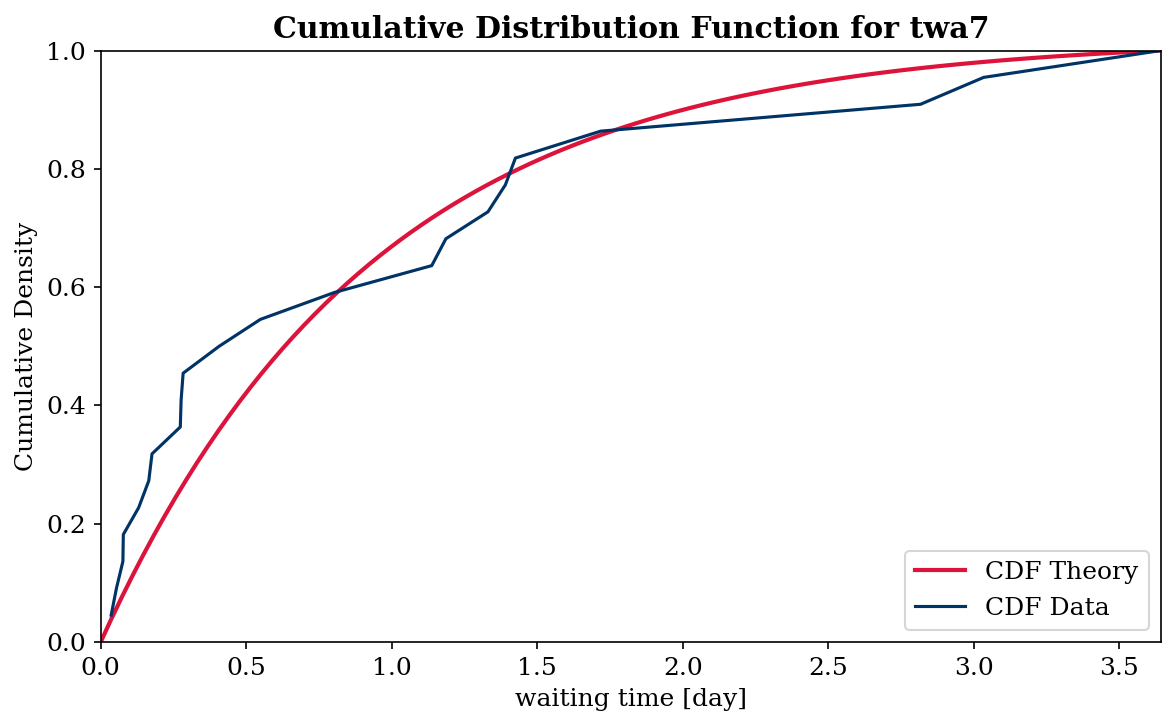

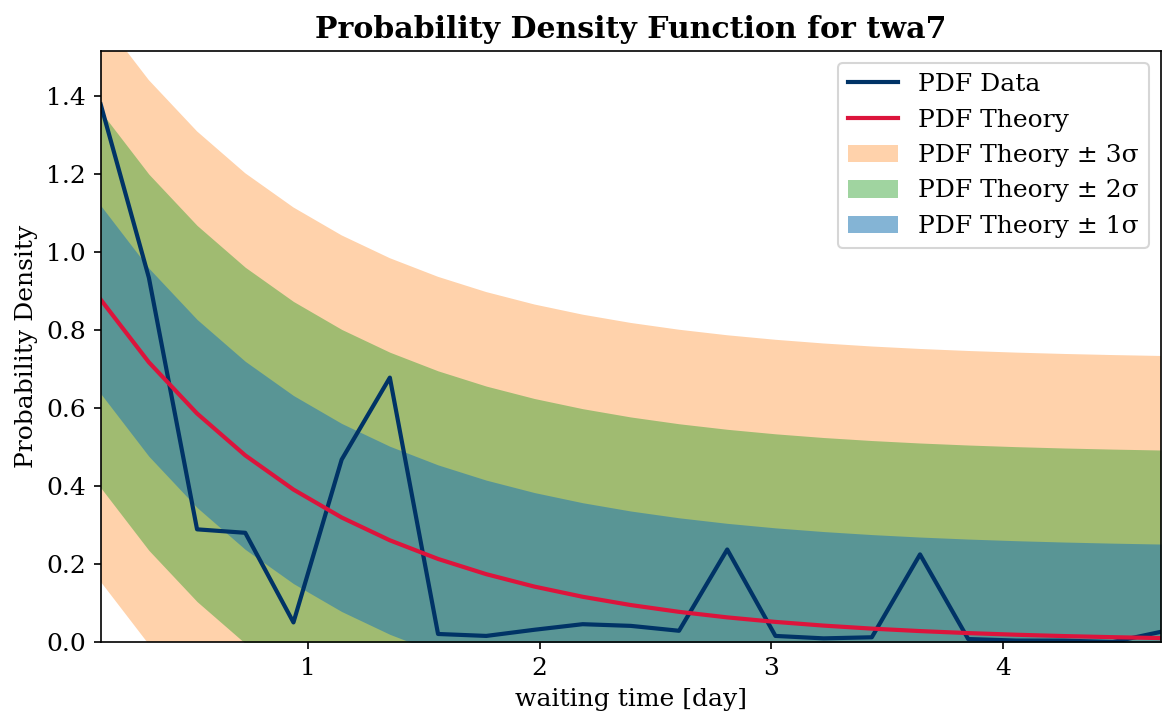

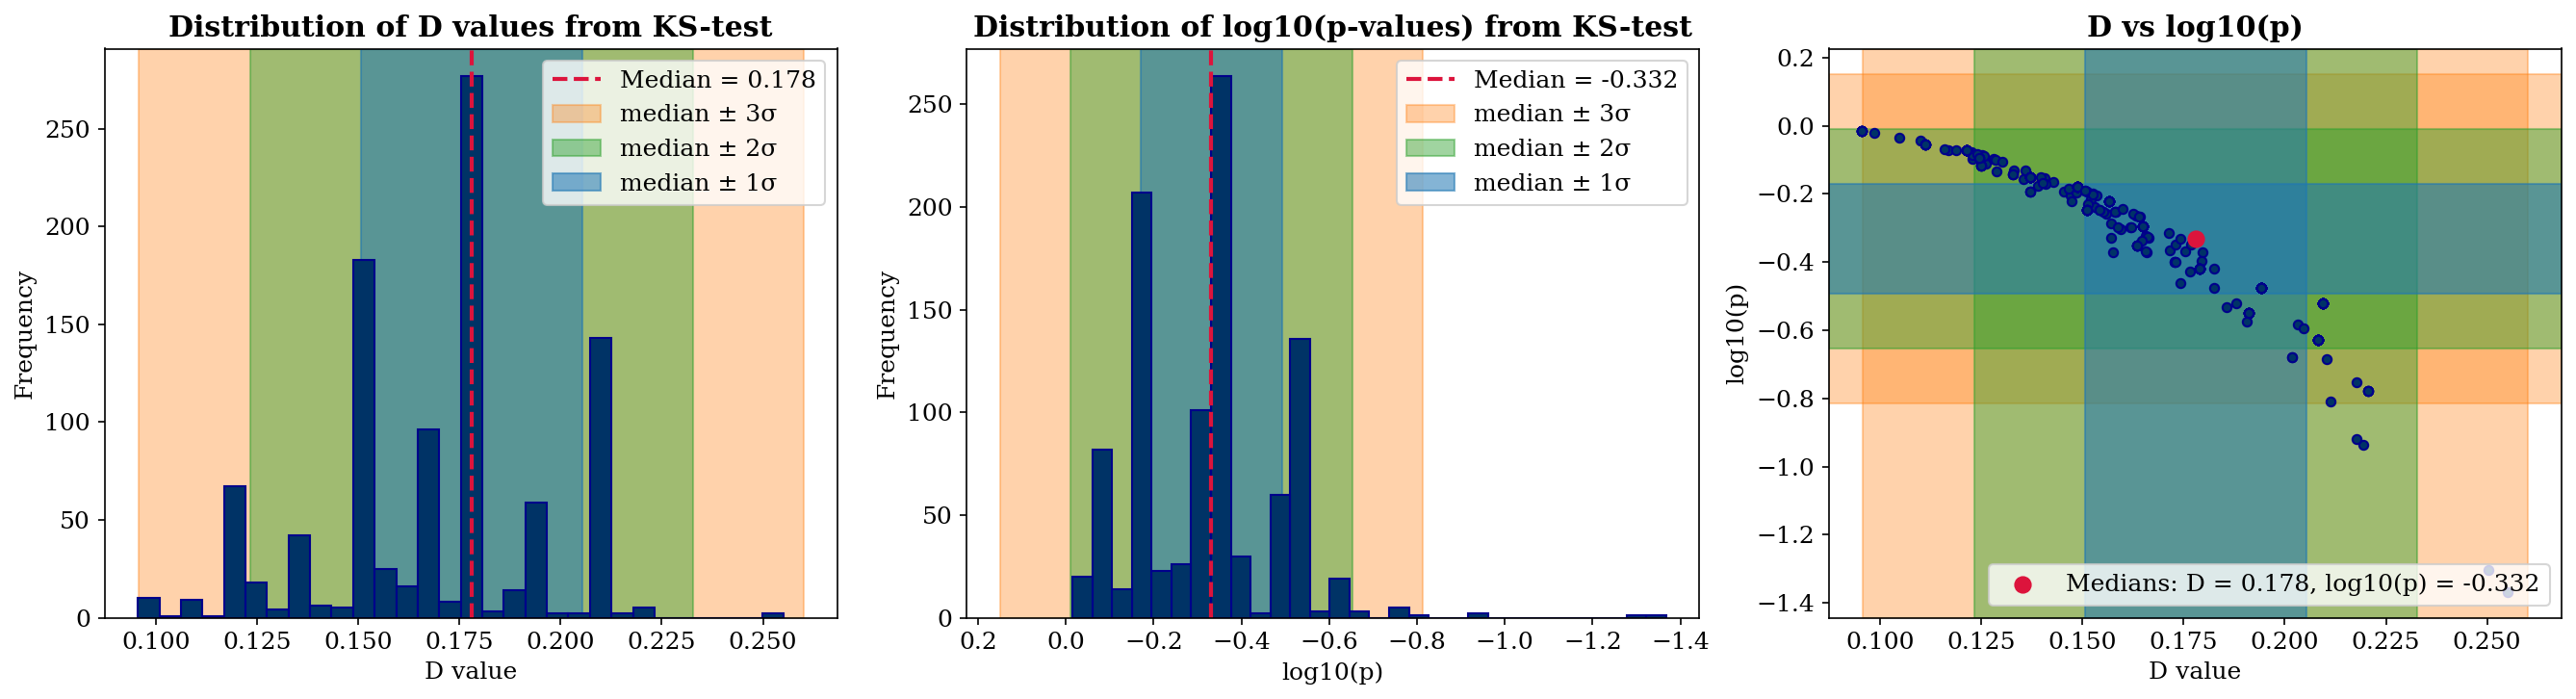

In [4]:
total_observing_time, time_index, time_gaps, t_gaps_start, t_gaps_end, mfr, t_flares = info_prepper(star_name, flare_data_path, observation_time_paths)

waiting_time_list, number_of_flares_list = waiting_time_calculator(number_of_simulations, t_gaps_start, t_gaps_end, mfr, t_flares, stacked)

D_values_mean, p_values_mean, D_values_median, p_values_median, D_values, p_values = statistics(waiting_time_list, t_gaps_start, total_observing_time, number_of_flares_list, plot, stacked, binsize)
